(ch:diffphot)=
# Differential Photometry

As you have learned from theory lecture, **differential photometry** (also called **relative photometry**) is a way to measure the magnitude (or flux) of your target when nearby object's magnitudes are known.

Here, we will combine the aperture photometry technique and star/solar system querying technique to perform the differential photometry.

1. Query the location of our asteroid in the image. (JPL HORIZONS)
1. Get the flux of our asteroid in the image.
1. Query the PS1 catalog stars in the FoV.
1. Get the flux of those stars in the image.
1. Analyze the image zero point we learned in the theory lecture.
1. Finally obtain the magnitude of our asteroid.

In [13]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

mm = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(mm.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-04-27 21:35:52 (KST = GMT+0900) 
0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.12.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.24.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8597
8 photutils  1.6.0
9 version_information 1.0.4


In [14]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import numpy as np

from astropy import units as u
from astropy.nddata import CCDData, Cutout2D
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.time import Time
from astropy.stats import sigma_clipped_stats

from astroquery.mast import Catalogs
from astroquery.jplhorizons import Horizons

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus)
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup

from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## Data Description
Below is the basic information of our observation, logged in the FITS header. For your information, the target we observed is a near-Earth asteroid (4179) Toutatis:

In [15]:
for key in ["DATE-OBS", "EXPTIME", "FILTER"]:
    print(f"{key:10s} {str(ccd.header[key]):20s} {ccd.header.comments[key]}")

DATE-OBS   2018-04-13T21:30:26  ISO-8601 observation date matching MJD-OBS
EXPTIME    60                   Exposure time [seconds]
FILTER     V                    Filter Name in the beam


## Target Photometry
As we learned, first query the ephemeris of the target.

In [16]:
objname = "4179"
observat = "B31"
t_obs = Time(ccd.header["DATE-OBS"]) + ccd.header["EXPTIME"] * u.s / 2
obj = Horizons(id=objname, location=observat, epochs=t_obs.jd)
q_obj = obj.ephemerides()

Now we perform aperture photometry to the target using
* Circular aperture
* Aperture radius 15 pixel
* Sky estimating annulus of 25-40 pixels.

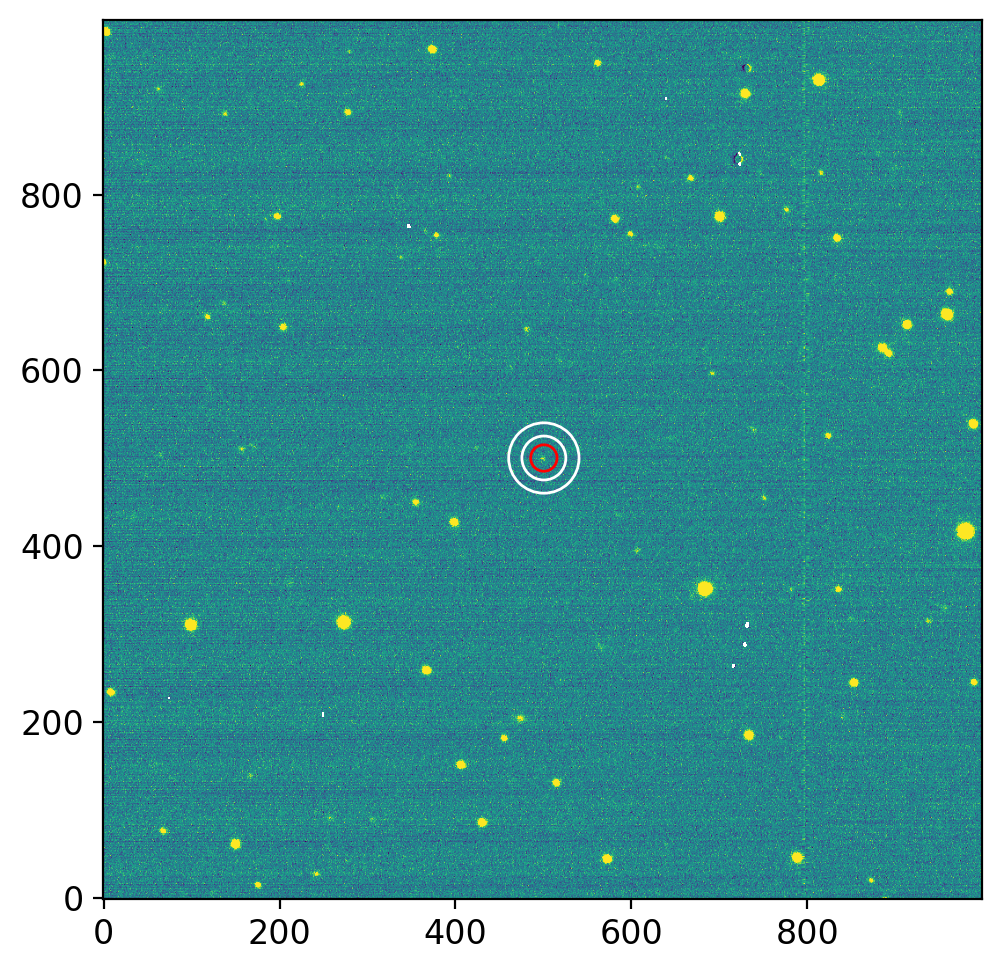

Instrumental magntiude = -3.060 ± 0.346


/Users/ysbach/miniforge3/envs/snuao/lib/python3.10/site-packages/ysphotutilpy/apphot.py:222: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(_arr/gn + (rd/gn)**2)


In [17]:
pos_sky = SkyCoord(q_obj["RA"][0], q_obj["DEC"][0], unit='deg')
pos_pix = pos_sky.to_pixel(wcs=ccd.wcs)
pos_pix = np.array([pos_pix[0], pos_pix[1]]).T

ap0 = CircularAperture(pos_pix, r=15)
an0 = CircularAnnulus(pos_pix, r_in=25, r_out=40)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ccd, zscale=True)
ap0.plot(color='r', lw=1, alpha=1, ax=axs)
an0.plot(color='w', lw=1, alpha=1, ax=axs)
plt.tight_layout()
plt.show();

phot_targ = ypu.apphot_annulus(ccd, ap0, an0)
m_targ = phot_targ['mag'][0]
dm_targ = phot_targ['merr'][0]
print(f"Instrumental magntiude = {m_targ:.3f} ± {dm_targ:.3f}")

```{note}
The instrumental magnitude of our target is v = -3.060 ± 0.346.
```

## Star Photometry

As we learned, first query the stars in the FoV:

In [18]:
pix_scale = 0.4*u.arcsec
center_xy = np.array(ccd.shape)/2
center_radec = ccd.wcs.wcs_pix2world(*center_xy, 0)
center_coo = SkyCoord(*center_radec, unit='deg')
fov_radius = np.sqrt((np.array(ccd.shape)**2).sum())/2 * pix_scale
q_ps = Catalogs.query_region(center_coo, radius=fov_radius, catalog="Panstarrs", 
                             data_release="dr2", table="mean")
# Change some column names for convenience.
q_ps["raMean"].name = "ra"
q_ps["decMean"].name = "dec"
q_ps["gMeanPSFMag"].name = "g"
q_ps["rMeanPSFMag"].name = "r"

# drop stars with unknown magnitudes
q_ps = q_ps.to_pandas().dropna(subset=["g", "r"])

# Calculate V and R, and their errors
q_ps["V"] = 0.006 + 0.474*q_ps["g"] + 0.526*q_ps["r"]
q_ps["R"] = -0.138 - 0.131*q_ps["g"] + 1.131*q_ps["r"]
q_ps["dV"] = np.sqrt(
    0.474**2*q_ps["gMeanPSFMagErr"]**2 
    + 0.526**2*q_ps["rMeanPSFMagErr"]**2 + 0.012**2
)
q_ps["dR"] = np.sqrt(
    0.131**2*q_ps["gMeanPSFMagErr"]**2
    + 1.131**2*q_ps["rMeanPSFMagErr"]**2 + 0.015**2
)
q_ps["dgr"] = np.sqrt(q_ps["gMeanPSFMagErr"]**2 + q_ps["rMeanPSFMagErr"]**2)

# Select only important columns
q2 = q_ps[["ra", "dec", "g", "r", "dgr", "V", "R", "dV", "dR"]].copy().reset_index(drop=True)

# Select only brighter than 22 mag
q2 = q2[(q2["V"] < 22) & (q2["R"] < 22)].copy()

# Calculate x, y position
coo = SkyCoord(q2["ra"], q2["dec"], unit='deg')
q2["x"], q2["y"] = ccd.wcs.wcs_world2pix(coo.ra, coo.dec, 0)

# Remove stars outside the image
q2 = q2[(q2["x"] > 20) & (q2["x"] < ccd.shape[1]-20) 
        & (q2["y"] > 20) & (q2["y"] < ccd.shape[0]-20)]

q2 = q2.reset_index(drop=True)

print(f"Total {len(q2)} stars from PS1 DR2")

Total 122 stars from PS1 DR2


Also, as we learned, run DAOFIND algorithm:

In [19]:
avg, med, std = sigma_clipped_stats(ccd.data)  # by default, 3-sigma 5-iteration.
finder = DAOStarFinder(
    fwhm=4,  # In reality, FWHM must be measured a priori using, e.g., `ginga`
    threshold=4 * std, 
    sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
    roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
    sigma_radius=1.5,           # default values 1.5
    ratio=1.0,                  # 1.0: circular gaussian
    exclude_border=True         # To exclude sources near edges
)

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
dao = finder(ccd.data - med)  
print(f"Total {len(dao)} stars from DAOStarFinder with threshold = {finder.threshold:.1f}")

Total 57 stars from DAOStarFinder with threshold = 34.9


### Strategy

There are multiple ways to match the star you queried above with the object visible in the image. Here, we use the X Y coordinates in ``q2``. Use it as the initial guess, crop the small portion (e.g., 7 by 7 pixel) of the image near the initial guess, and do centroiding at each position in the image iteratively until it converges.

So our strategy will be:
1. Drop the stars with close distance in queried catalog stars (overlapping stars)
2. Drop the stars with close distance from DAOFIND (overlapping stars)
3. Match the stars (i.e., append the xy position from DAOFIND to corresponding queried stars.)
    * Thus, queried catalog stars with no matching DAOFIND star will be removed.
4. Do photometry of stars

```{note}
Some may ask why we should drop stars from DAOFIND, because we have already dropped nearby stars in previous step (stars from query). In the previous step, we dropped nearby stars based solely on the catalogued positions. Some objects may be bright enough but not catalogued for some reason, so they are detected only by this star finding process. In unfortunate cases, such stars may be near to the star that we may have expected to be "isolated" from the nearby object removal in the above. What if we skip the above process but drop stars only based on the star finding algorithm? There might be faint object which were bright enough to be catalogued, but unfortunately unresolved in our image. Then as they are not distinguishable in our image, our instrumental magnitude will be the sum of the objects, while we will use the catalogue magnitude of only one of the overlapping stars. Thus, **the two processes are both necessary**.
```


```{admonition} Centroiding
:class: note, dropdown
Sometimes you may notice that **stars are not at the expected locations**. There can be several reasons, such as wrong WCS, image distortion, moving object, transient (supernovae), cosmic-ray confusion, etc. One possibility is the proper motion of stars. If the queried star has a large proper motion (say it moved 10 arcsec from J2000 to the current epoch, say J2020.2) and the image has small pixel scale, say 0.5 arcsec per pixel, so that your star is away from the queried position by more than 20 pixels. Then the cropped subimage (7 by 7 pixel) centered at the expected location does not contain the star. Thus, the centroiding algorithm will result in an unrealistic result.

Although **"centeroid"** (or finding center of the star) sounds like an easy task, the centroiding algorithms actually do not converge many times, so you may have hard time coding them. Algorithmically, it is actually one of the hardest problem especially under the low SNR. You may refer to [Stetson87](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract) ([IRAF/DAOPHOT algorithm](https://iraf.readthedocs.io/en/latest/tasks/noao/digiphot/daophot/centerpars.html)). Also, you can look into IRAF's centering algorithms such as [IMEXAMINE](https://iraf.readthedocs.io/en/latest/tasks/images/tv/imexamine.html), which is a centering algorithm for radial profile.

A lot of practical tricks can be developed, and any observational astronomer will use slightly different algorithm from the other colleagues. However, a researcher should choose one that does not affect the final result much.
```


```{important}
Before proceed further, please read and follow the tutorial of [photutils/grouping](https://photutils.readthedocs.io/en/stable/grouping.html).
```

### Drop Closely Located Stars from Catalog

Since we have already queired stars, let me drop stars with close distance (20 pixels in this example, using DAOGROUP algorithm):

In [20]:
def group_stars(table, crit_separation, xcol="x", ycol="y", index_only=True):
    ''' Group stars using DAOGROUP algorithm and return row indices.

    Parameters
    ----------
    table : astropy.table.Table
        The queried result table.

    crit_separation : float or int
        Distance, in units of pixels, such that any two stars separated by less
        than this distance will be placed in the same group.

    xcol, ycol : str, optional
        The column names for x and y positions. This is necessary since
        `~photutils.DAOGroup accepts a table which has x y positions designated
        as ``"x_0"`` and ``"y_0"``.

    index : bool, optional
        Whether to return only the index of the grouped rows (group information
        is lost) or the full grouped table (after group_by).

    Notes
    -----
    Assuming the psf fwhm to be known, ``crit_separation`` may be set to
    ``k * fwhm``, for some positive real k.

    See Also
    --------
    photutils.DAOStarFinder

    References
    ----------
    [1] Stetson, Astronomical Society of the Pacific, Publications,
        (ISSN 0004-6280), vol. 99, March 1987, p. 191-222.
        Available at: http://adsabs.harvard.edu/abs/1987PASP...99..191S

    Return
    ------
    gtab: Table
        Returned when ``index_only=False``. The table underwent
        ``.group_by("group_id")``.

    grouped_rows: list
        Returned when ``index_only=True``.
        The indices of the rows which are "grouped" stars. You may remove such
        rows using ``table.remove_rows(grouped_rows)``.
    '''

    # Convert to astropy.Table because DAOGroup only accepts astropy.Table.
    if not isinstance(table, Table):
        table = Table.from_pandas(table)
    tab = table.copy()

    tab[xcol].name = "x_0"
    tab[ycol].name = "y_0"
    try:
        gtab = DAOGroup(crit_separation=crit_separation)(tab)
    except IndexError:  # empty tab (len(tab) == 0)
        gtab = tab
        gtab["group_id"] = []
        gtab["id"] = []

    if not index_only:
        gtab["x_0"].name = xcol
        gtab["y_0"].name = ycol
        return gtab
    else:
        gid, gnum = np.unique(gtab["group_id"], return_counts=True)
        gmask = gid[gnum != 1]  # group id with > 1 stars
        grouped_rows = []
        for i, gid in enumerate(gtab["group_id"]):
            if gid in gmask:
                grouped_rows.append(i)
        return grouped_rows


rows2rm = group_stars(q2, crit_separation=20) 
q2_close = q2.drop(rows2rm, axis=0).reset_index(drop=True)

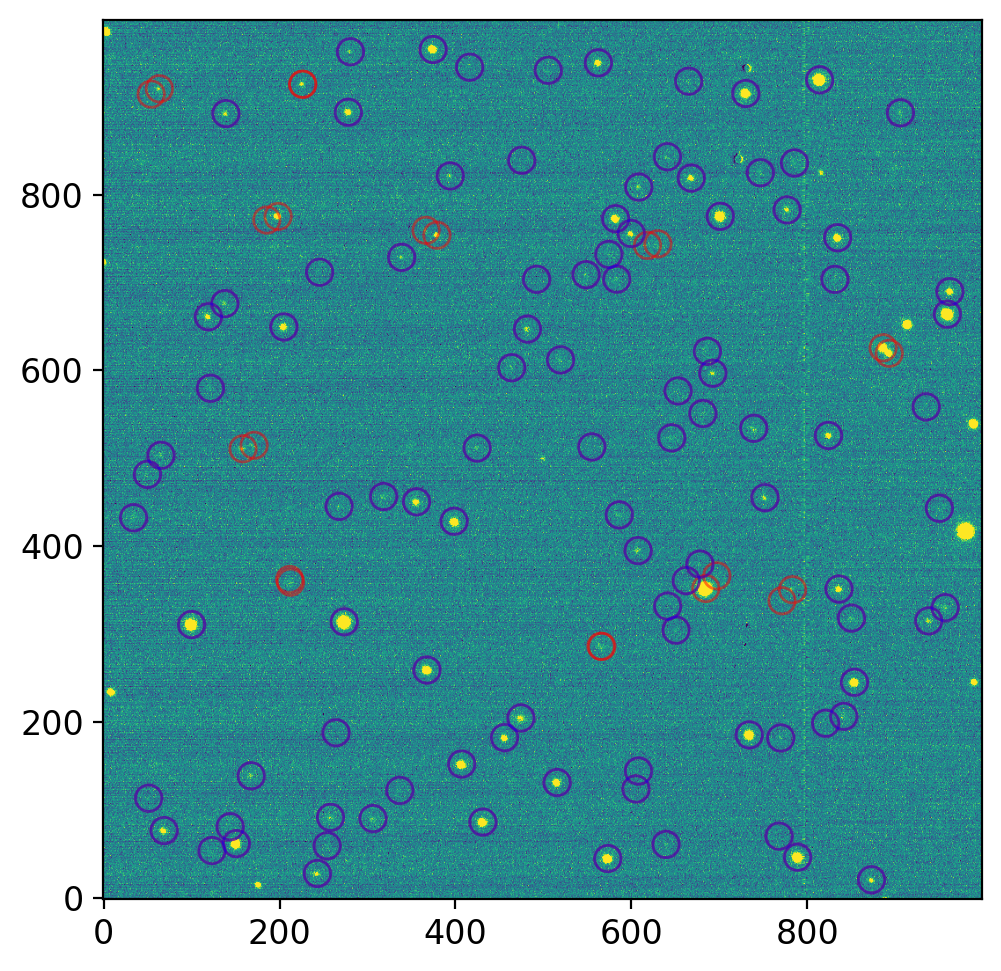

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

aps_all = CircularAperture(np.array([q2["x"], q2["y"]]).T, r=15)
aps_close = CircularAperture(np.array([q2_close["x"], q2_close["y"]]).T, r=15)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_all.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="blue", lw=1, alpha=0.5, ax=axs)

plt.tight_layout()
plt.show();

The stars indicated by red circles are the stars that are **too close to each other**. These are removed in ``q2_close`` DataFrame. (rigorously speaking, they are close to each other based on the catalog, not based on the observed image)


### Drop Closely Located Stars from DAOFIND

Now drop the stars that has nearby objects (based on DAOFIND result and reuse the previously used ``group_stars``):

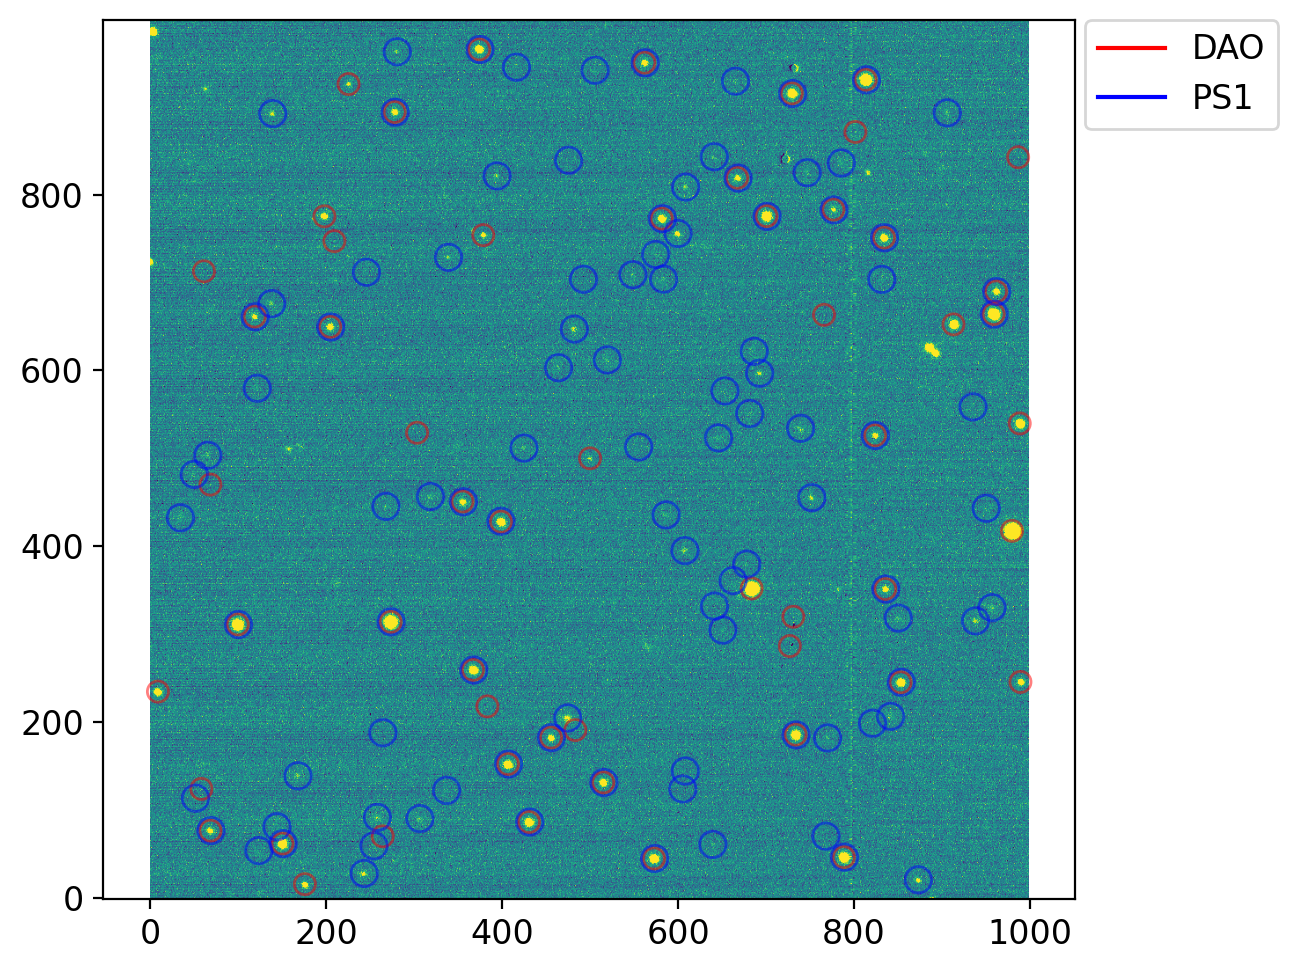

In [22]:
# Drop nearby objects
rows2rm = group_stars(dao, crit_separation=20, xcol="xcentroid", ycol="ycentroid")
dao = dao.to_pandas().drop(rows2rm, axis=0).reset_index(drop=True)

# Plot
aps_dao = CircularAperture(np.array((dao['xcentroid'], dao['ycentroid'])).T, r=12)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_dao.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="b", lw=1, alpha=0.5, ax=axs)
for c, l in zip("rb", ["DAO", "PS1"]):
    axs.plot([], [], c=c, label=l)
axs.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show();

````{admonition} Practice
:class: tip
Change ``roundlo=-1.0, roundhi=1.0``, to ``roundlo=-.5, roundhi=.5``, then see our object, at the center of image, is not detected from star finder. 

```{info}
This happens *partly* because the observation was made in non-sidereal tracking mode, i.e., the moving object (our asteroid) become slightly elliptical on the CCD (i.e., its ``round`` parameter gets larger). Note that some of the stars are undetected too.
```

Also, change parameters, such as ``sigma_radius`` to ``2``. The red star which is missed in the star finder will now be found.
````

### Cross-Match Catalog & DAOFIND
Match for each position from the catalog, find if there is any star found by DAOFIND within 10x10 pixel (*absolute delta-x and delta-y smaller than 5*). If multiple stars in this box, select the closest. Then add the ``xcentroid`` and ``ycentroid`` information to the queried table (``q2``).

In [23]:
q2_close["xcentroid"], q2_close["ycentroid"] = None, None

for i, row in q2_close.iterrows():
    x, y = row["x"], row["y"]
    # Find closest DAOStarFinder source with distance no larger than 5 pix
    dx = dao["xcentroid"] - x
    dy = dao["ycentroid"] - y
    candidate = dao[(abs(dx) < 5) & (abs(dy) < 5)]
    if len(candidate) == 0:
        continue

    # Find the closest one
    if len(candidate) > 1:
        candidate = candidate[np.argmin(np.hypot(dx, dy))]
    
    q2_close.loc[i, "xcentroid"] = candidate["xcentroid"].iloc[0]
    q2_close.loc[i, "ycentroid"] = candidate["ycentroid"].iloc[0]
q2_close = q2_close.dropna(axis=0, subset="xcentroid").reset_index(drop=True)

### Aperture Photometry of Stars
Do the aperture photometry to the stars, and add this information to the queried table (``q2``). Identical to our target,

* Circular aperture
* Aperture radius 15 pixel
* Sky estimating annulus of 25-40 pixels.

In [24]:
q2_xy = np.array([q2_close["xcentroid"], q2_close["ycentroid"]]).T
ap_stars = CircularAperture(q2_xy, r=15)
an_stars = CircularAnnulus(q2_xy, r_in=25, r_out=40)
phot = ypu.apphot_annulus(ccd, ap_stars, an_stars).drop(["xcenter", "ycenter"], axis=1)
phot = q2_close.join([phot])

/Users/ysbach/miniforge3/envs/snuao/lib/python3.10/site-packages/ysphotutilpy/apphot.py:222: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(_arr/gn + (rd/gn)**2)


## Find Standardization

Our observation was made in V-band (check ``ccd.header["FILTER"]``), so we need to use the V-band magnitude.

Two methods are shown to calculate the image zero point. We learned:

$$
  M_f = m_f + (\mathrm{effect\ of\ atmosphere}) + (\mathrm{effect\ of\ CCD}) \\
    \approx m_f - k_f' X - k_f''XC + z_f + k_f C \\
$$
where
* $ f $: The filter (V, B, g', etc). In our case, V.
* $ X $: airmass (the simplest approximation is the secant of zenith angle, $ \sec Z $).
* $ M_f $: The **standard** apparent magnitude (or the **true** apparent magnitude) at filter $ f $.
* $ m_f $: The **instrumental** magnitude ($ m_f = -2.5 \lg N $).
* $ C $: The **true** color index, e.g., $ B - V $ or $ r' - i' $. (Not necessarily include filter $ f $, but it is better that the wavelength ranges of the selected two filters "*contain*" the range of $ f $ for interpolation purpose. Also in many classical literatures, you will see the $ C $ in this equation is the *observed* color, not the true color. This is just a matter of preference.)
* $ k_f' $: The first order extinction coefficient at filter $ f $.
* $ k_f'' $: The second order extinction coefficient at filter $ f $.
* $ z_f $: The zero point at filter $ f $.
* $ k_f $: The system transform coefficient at filter $ f $.
* Note: In the lecture note, lower- and upper-cased letters are used for the **instrumental** and **true** magnitudes, respectively (For example, $ v $, $ b $, $ m_{g'} $ are instrumental magnitudes of an object and $ V $, $ B $, and $ M_{g'} $ are true appparent magnitudes of it.).

In the simplest case, 

$$
  v = V + Z
$$
for the zero point $Z$ (i.e., assume all the terms are constant). In our case, we calculate the zero point in this single image, and since the airmass $X$ is identical for every object in the FoV, this is quite a reasonalble guess. The color-term will be shown to be negligible (see below).

Note that putting $v (= m_f)$ to the LHS is to put it in the ordinate in the fitting process below.

```{note} 
The [weighted mean with variance weighting](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Variance_weights) of $x_i$ is given as

$$ 
\bar{x} = \frac{\sum_i x_i / \sigma_i^2}{\sum_i 1 / \sigma_i^2} 
\quad;\quad
\sigma_{\bar{x}} = \frac{1}{\sqrt{\sum_{i=1}^{N} 1 / \sigma_i^2} } ~.
$$

The weighted-mean of variance weight is widely used because it is *the* solution of the chi-square minimization (least square) technique, for Gaussian errors. In otherwords, this is the least-square fitting solution of a *constant function* to the data.
```

In the simplest formalism, $Z = v - V$ can be calculated for multiple stars. The $Z$ and $dZ$ values can be calculated from this weighed mean, using $Z_i$ for the i-th stars will be the zero point value. The error-bar of each can be roughly estimated as $dZ_i = \sqrt{dv^2 + dV^2}$. However, if the error-bar of each star (i.e., the dv and dV values) are not correctly measured (many times it is the case), it is sometimes better to use simple sample standard deviation: ``np.std(Z_i, ddof=1)``. Normally many people use whichever is larger: 

$$
  dZ = \mathrm{max} \left( \frac{1}{\sqrt{\sum 1/dZ_i^2}}, \frac{\mathtt{np.std(Z_i, ddof=1))}}{\sqrt{N}} \right) 
$$

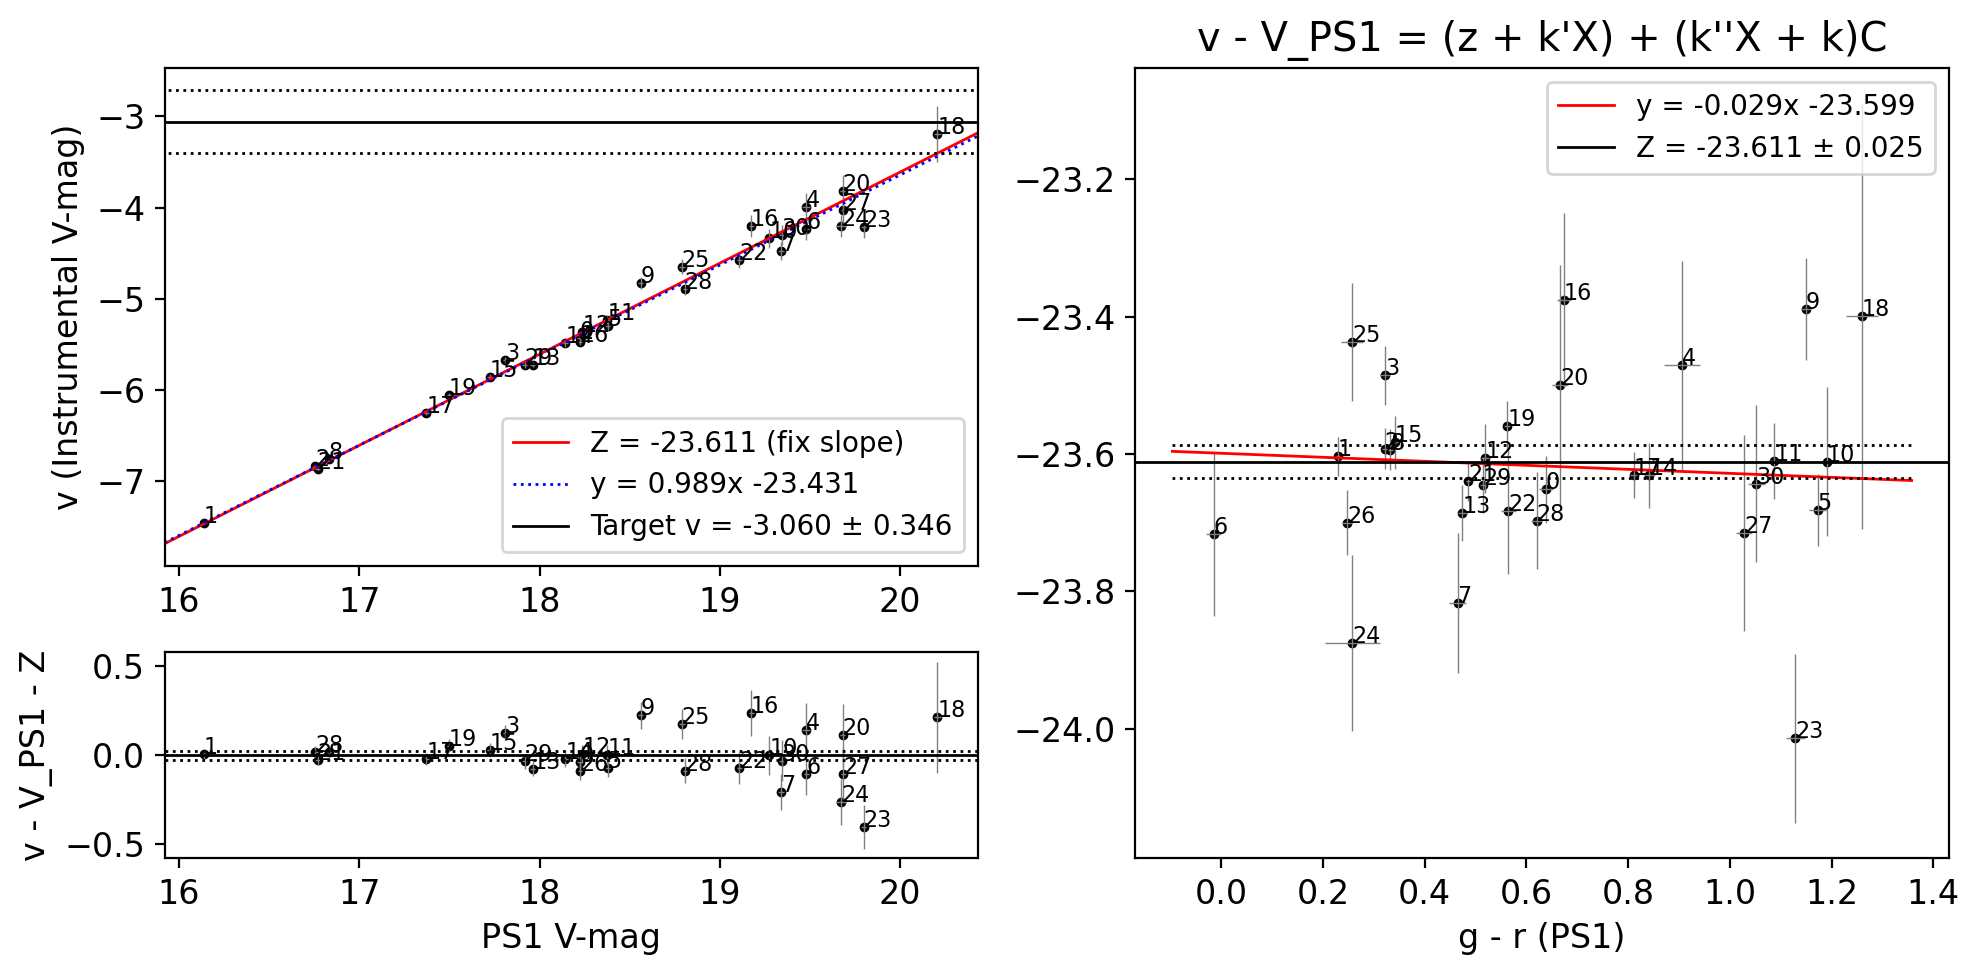

In [49]:
from scipy.optimize import curve_fit

def linf(x, a, b):
    return a + b*x

mcat, dmcat = phot["V"], phot["dV"]
mobs, dmobs = phot["mag"], phot["merr"]
color = phot["g"] - phot["r"]
dmtot = np.sqrt(dmcat**2 + dmobs**2)

# === Calculate zero point and errors
zeropt = np.average(mobs - mcat, weights=1/dmtot**2)
dzeropt = np.max([1/np.sqrt(np.sum(1/dmtot**2)), np.std(mobs - mcat, ddof=1)/np.sqrt(len(mcat))])
dmtot2 = np.sqrt(dmtot**2 + dzeropt**2)

# === Find fitting lines
# Search for the usage of scipy.optimize.curve_fit.
poptm, _ = curve_fit(linf, mcat, mobs, sigma=dmobs, absolute_sigma=True)
poptc, _ = curve_fit(linf, color, mobs-mcat, sigma=dmtot2, absolute_sigma=True)

# === Plot
# --- Set some useful things
errkw = dict(marker="", ls="", ecolor="gray", elinewidth=0.5)

# --- Main plot with error bars and fitting lines
fig, axs = plt.subplot_mosaic("mc\nmc\nrc", figsize=(10, 5))
# m = magnitudes, c=colors, r=residuals
axs["m"].plot(mcat, mobs, "k.", ms=5)
axs["m"].errorbar(mcat, mobs, xerr=dmcat, yerr=dmobs, **errkw)
axs["r"].plot(mcat, mobs - mcat - zeropt, "k.", ms=5)
axs["r"].errorbar(mcat, mobs - mcat - zeropt, xerr=dmcat, yerr=dmtot2, **errkw)
axs["c"].plot(color, mobs - mcat, "k.", ms=5)
axs["c"].errorbar(color, mobs - mcat, xerr=phot["dgr"], yerr=dmtot2, **errkw)

mm = np.array(axs["m"].get_xlim())
cc = np.array(axs["c"].get_xlim())

# Fitted lines
axs["m"].plot(mm, zeropt + mm, "r-", lw=1, label=f"Z = {zeropt:+.3f} (fix slope)")
axs["m"].plot(mm, linf(mm, *poptm), "b:", lw=1, label=f"y = {poptm[1]:.3f}x {poptm[0]:+.3f}")
axs["c"].plot(cc, linf(cc, *poptc), "r-", lw=1, label=f"y = {poptc[1]:+.3f}x {poptc[0]:+.3f}")

# --- Some codes to make the plot prettier
axs["m"].axhline(m_targ, color="k", lw=1, label=f"Target v = {m_targ:.3f} ± {dm_targ:.3f}")
axs["m"].hlines([m_targ+dm_targ, m_targ-dm_targ], *axs["m"].get_xlim(), color="k", lw=1, ls=":")

for i, row in phot.iterrows():
    axs["m"].text(row["V"], row["mag"], i, fontsize=8)
    axs["r"].text(row["V"], row["mag"] - row["V"] - zeropt, i, fontsize=8)
    axs["c"].text(row["g"] - row["r"], row["mag"] - row["V"], i, fontsize=8)

axs["m"].set(xlim=mm, ylabel="v (Instrumental V-mag)")
axs["r"].set(xlim=mm, ylim=np.array([-1, 1])*np.max(np.abs(axs["r"].get_ylim())), 
             ylabel="v - V_PS1 - Z", xlabel="PS1 V-mag")
axs["c"].set(title="v - V_PS1 = (z + k'X) + (k''X + k)C", xlabel="g - r (PS1)")

axs["r"].axhline(0, color="k", lw=1)
axs["r"].hlines([dzeropt, -dzeropt], *mm, color="k", lw=1, ls=":" )
axs["c"].axhline(zeropt, color="k", lw=1, label=f"Z = {zeropt:.3f} ± {dzeropt:.3f}")
axs["c"].hlines([zeropt+dzeropt, zeropt-dzeropt], *cc, color="k", lw=1, ls=":" )

axs["m"].legend(fontsize=10)
axs["c"].legend(fontsize=10)

plt.tight_layout()
plt.show()

1. The linearity curve (top left) looks quite linear, in that the fitted linear line has a slope of 0.989 ~ 1.0.
    * **NOTE**: The target has instrumental magnitude v = -3.060, which is at the faint-end of the field stars.
2. The residual plot (bottom left) shows the scatter gets larger for fainter object, as expected. 
3. The color plot shows no clear trend of the ``Z`` value against the g-r color (slope ~ 0.03) and the linear fit is within 1-sigma error-bar of Z value. As we cover the color of range ~0 to ~1.2, we conclude that we can safely ignore any color effect within the accuracy we want.
    * **NOTE**: The uncertainty that will arise due to the color term will be ~ 0.025x0.5 ~ 0.01 mag, assuming the ± 0.5 mag of color uncertainty of our object.

## Final result

Since we know the zero point value, we can calculate the V-magnitude of our target based on the Z value and the instrumental magnitude value:

In [52]:
phot_targ["V"] = phot_targ["mag"] - zeropt
phot_targ["dV"] = np.sqrt(phot_targ["merr"]**2 + dzeropt**2)
phot_targ[["xcenter", "ycenter", "V", "dV"]]

xcenter     ycenter          V        dV
0  500.582912  500.435615  20.550977  0.347353

* The instrumental mag: v = -3.060 ± 0.346
* The standard mag: V = 20.551 ± 0.347